In [23]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import nltk
import nltk.sentiment
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from time import strftime

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

I don't think we should concat these, since the headlines df doesn't have dates.
I am going to continue focusing on the episodes dataset.

In [13]:
#epi_head_df = pd.concat(
    #map(pd.read_csv, ['episodes.csv', 'headlines.csv']), ignore_index= True)
#epi_head_df.head()

,id,program,title,episode_date,headline
0,98814,Morning Edition,Senate Ushers In New Year With 'Fiscal Cliff' ...,2013-01-01,NaN
1,98824,Morning Edition,Cheap Bubbly Or Expensive Sparkling Wine? Look...,2012-12-31,NaN
2,98821,Morning Edition,U.S. Gas Prices Reach Record Level In 2012,2013-01-01,NaN
3,98806,Morning Edition,House Approves 'Fiscal Cliff' Measure,2013-01-02,NaN
4,98823,Morning Edition,The Fiscal Cliff: A Love Story,2012-12-31,NaN


Decided not to use headlines at all, but keeping this here just in case.

In [14]:
headlines = pd.read_csv('headlines.csv')
headlines.head()

,id,headline
0,524288,"For Some, The Decision To Enlist Offers Direction"
1,524289,Whither The Astronauts Without A Shuttle?
2,524292,Tour Winner May Not Be First Over Finish Line
3,262153,California College Students Walk Out Of Class ...
4,524298,New Theory On 'Shaken Baby Syndrome'


In [108]:
episodes = pd.read_csv('episodes.csv')
episodes.head()

,id,program,title,episode_date
0,98814,Morning Edition,Senate Ushers In New Year With 'Fiscal Cliff' ...,2013-01-01
1,98824,Morning Edition,Cheap Bubbly Or Expensive Sparkling Wine? Look...,2012-12-31
2,98821,Morning Edition,U.S. Gas Prices Reach Record Level In 2012,2013-01-01
3,98806,Morning Edition,House Approves 'Fiscal Cliff' Measure,2013-01-02
4,98823,Morning Edition,The Fiscal Cliff: A Love Story,2012-12-31


In [37]:
utterances = df.utterance
utterances.head()

0    It's a 2,200-mile race. To give some sense of ...
1    So for a top competitor like Lance to try to m...
2    So in every team, presumably there's one star,...
3    That's right. Each team has nine riders. And w...
4    So slipstream, this is like drafting in car ra...
Name: utterance, dtype: object

_____

Below is the code from Joshua's notebook, he noticed that the episode titles and the utterances coordinated. Thought I'd pull that into here, as it is important for further exploration.

In [30]:
# find utterance count per episode
utterances_df.episode.value_counts()

19633    569
67407    567
35108    552
57481    539
73336    492
        ... 
85486      1
1512       1
92229      1
82878      1
68609      1
Name: episode, Length: 104920, dtype: int64

In [33]:
# check episode content to see if it matches episode id
df[df.episode == 92554].utterance.to_list()

["Good morning. I'm David Greene. Here's the weather forecast for Albuquerque, New Mexico today - cloudy with a chance of grasshoppers. Yes, that's right. The animals are swarming the city so densely, local radar is mistaking them for rain crowds. These insects are hovering in masses as high as a thousand feet up. Officials say this is the worst infestation in 20 years, but it should pass soon. With any luck, it will go back to raining rain - helping to clean up the mess left behind by these grasshoppers. You're listening to MORNING EDITION."]

In [29]:
# check ep_df.id = df.episode
episodes[episodes.id == 92554].title.to_list()

["Albuquerque's Weather? Cloudy With A Chance of Grasshoppers"]

### Joshua's takeaways:
(Keeping for future use)

- There are episodes with one utterance, showing less interview setting and more reporting.

- episodes.id == df.episode

______

In [48]:
df.shape

(104920, 1)

In [107]:
episodes.shape

(105848, 4)

In [109]:
df = pd.read_csv('utterances.csv')
df.head()

,episode,episode_order,speaker,utterance
0,57264,9,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...","It's a 2,200-mile race. To give some sense of ..."
1,57264,10,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",So for a top competitor like Lance to try to m...
2,57264,11,"NEAL CONAN, host","So in every team, presumably there's one star,..."
3,57264,12,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's right. Each team has nine riders. And w...
4,57264,13,"NEAL CONAN, host","So slipstream, this is like drafting in car ra..."


In [110]:
df.columns =['id', 'episode_order', 'speaker', 'utterance']

In [111]:
# joining utterances df ('df') and episodes on 'id'
joined_df = pd.merge(df, episodes, on = 'id')
joined_df

,id,episode_order,speaker,utterance,program,title,episode_date
0,57264,9,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...","It's a 2,200-mile race. To give some sense of ...",Talk of the Nation,How To Watch The Tour De France,2010-07-12
1,57264,10,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",So for a top competitor like Lance to try to m...,Talk of the Nation,How To Watch The Tour De France,2010-07-12
2,57264,11,"NEAL CONAN, host","So in every team, presumably there's one star,...",Talk of the Nation,How To Watch The Tour De France,2010-07-12
3,57264,12,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's right. Each team has nine riders. And w...,Talk of the Nation,How To Watch The Tour De France,2010-07-12
4,57264,13,"NEAL CONAN, host","So slipstream, this is like drafting in car ra...",Talk of the Nation,How To Watch The Tour De France,2010-07-12
...,...,...,...,...,...,...,...
3199853,69759,31,RAY MAGLIOZZI,"Oh, I don't know about that.",All Things Considered,Should You Warm Up Your Car Before Driving To ...,2017-12-29
3199854,69759,32,_NO_SPEAKER,(LAUGHTER),All Things Considered,Should You Warm Up Your Car Before Driving To ...,2017-12-29
3199855,69759,33,"ROBERT SIEGEL, HOST","Ray Magliozzi, co-host of the longtime NPR pro...",All Things Considered,Should You Warm Up Your Car Before Driving To ...,2017-12-29
3199856,69759,34,RAY MAGLIOZZI,"Nice to talk to you, too, Robert - my pleasure.",All Things Considered,Should You Warm Up Your Car Before Driving To ...,2017-12-29


In [114]:
joined_df = joined_df.groupby('id')

In [116]:
joined_df.first()

,episode_order,speaker,utterance,program,title,episode_date
id,,,,,,
1,1,"LULU GARCIA-NAVARRO, HOST",The impeachment inquiry picks up tomorrow wher...,Weekend Edition Sunday,Sunday Politics,2019-10-06
2,1,"LULU GARCIA-NAVARRO, HOST",President Trump has announced another new immi...,Weekend Edition Sunday,How Immigrants Use Health Care,2019-10-06
3,1,"LULU GARCIA-NAVARRO, HOST","Now to Hong Kong, where anti-government protes...",Weekend Edition Sunday,Hong Kong Protesters Defy Face Mask Ban,2019-10-06
4,1,"LULU GARCIA-NAVARRO, HOST",After Hurricane Dorian hit the Bahamas last mo...,Weekend Edition Sunday,Aid Group Of Veterans Assists In Bahamas,2019-10-06
5,25,JIM PARKER,I agree a hundred percent the climate is chang...,Weekend Edition Sunday,"The Gulf Of Maine Is Warming, And Its Whales A...",2019-10-06
...,...,...,...,...,...,...
140746,16,"JENNIFER LUDDEN, host",Now are they accredited to an American bar?,All Things Considered,Lawyers Find Work Outsourced,2005-05-01
140747,1,"JENNIFER LUDDEN, host",The United States is home to more than 150 vol...,All Things Considered,Geologists Stress Volcano Risk,2005-05-01
140748,1,"JENNIFER LUDDEN, host",This is ALL THINGS CONSIDERED from NPR News. ...,All Things Considered,Disneyland to Celebrate 50 Years,2005-05-01


Below is the code for bigrams. This is not completed, and is just here for when I get to that point.

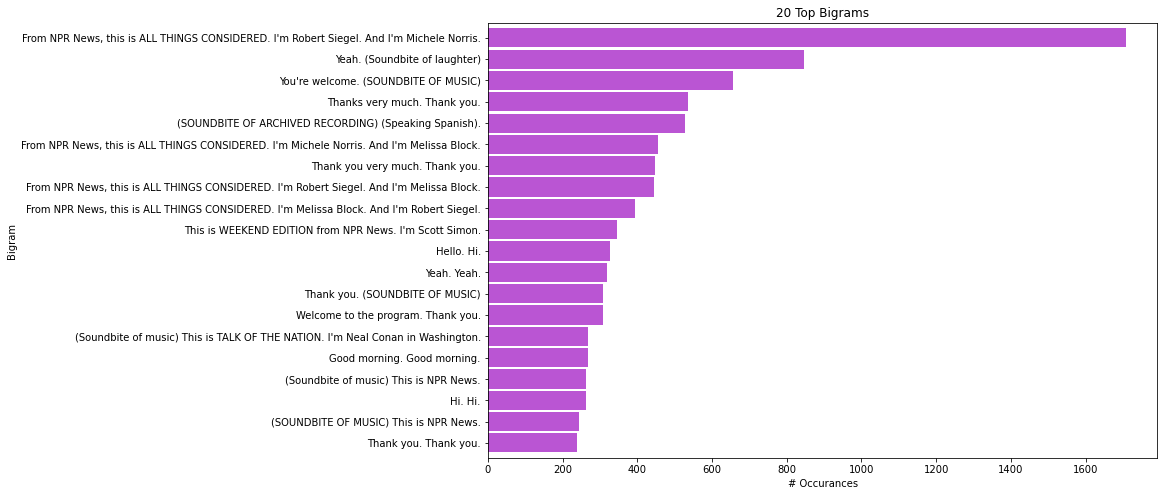

In [24]:
# Calculate bigrams
bigrams = (pd.Series(nltk.ngrams(utterances, 2))
                      .value_counts()
                      .head(20))
# Vizualize Bigrams
bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Top Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)